# Notebook to see the best model metrics -> to use in report

In [7]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import joblib
import pandas as pd
import numpy as np

## Loading the dataset

In [3]:
# loading the dataset

# paths
train_csv = "../data/train.csv"
val_csv   = "../data/val.csv"
test_csv  = "../data/test.csv"

# load; all of them have 2 columns: Text, Label
train = pd.read_csv(train_csv)
val   = pd.read_csv(val_csv)
test  = pd.read_csv(test_csv)

print("Train:", train.shape, "Val:", val.shape, "Test:", test.shape)

# cleaning the dataset - lowercases and removes extra whitespaces in every text
def clean_data(text):
    #check for actual missing values
    if pd.isna(text) or text is None:
        return None
        
    #convert to string and strip whitespace
    text_str = str(text).lower().strip()
    
    #check for literal string "None", "nan", or empty
    if text_str in ['none', 'nan', 'null', '']:
        return None
    
    return text_str

train['text_clean'] = train['Text'].apply(clean_data)
train = train.dropna(subset=['text_clean']).reset_index(drop=True)
val['text_clean']   = val['Text'].apply(clean_data)
val = val.dropna(subset=['text_clean']).reset_index(drop=True)
test['text_clean']  = test['Text'].apply(clean_data)
test = test.dropna(subset=['text_clean']).reset_index(drop=True)

# fit on training texts and transform all splits
tfidf = joblib.load("../artifacts/punctuation/tfidf_vectorizer.joblib")

X_train = tfidf.transform(train['text_clean'])
X_val   = tfidf.transform(val['text_clean'])
X_test  = tfidf.transform(test['text_clean'])
y_test  = test['Label'].astype(int).values

print("TF-IDF shapes:", X_train.shape, X_val.shape, X_test.shape)

Train: (50587, 2) Val: (6324, 2) Test: (6324, 2)


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfTransformer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator TfidfVectorizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


TF-IDF shapes: (50554, 5000) (6321, 5000) (6320, 5000)


## Confusion matrix

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelBinarizer from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/sklearn/base.py:442: InconsistentVersionWarning: Trying to unpickle estimator MLPClassifier from version 1.3.0 when using version 1.7.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


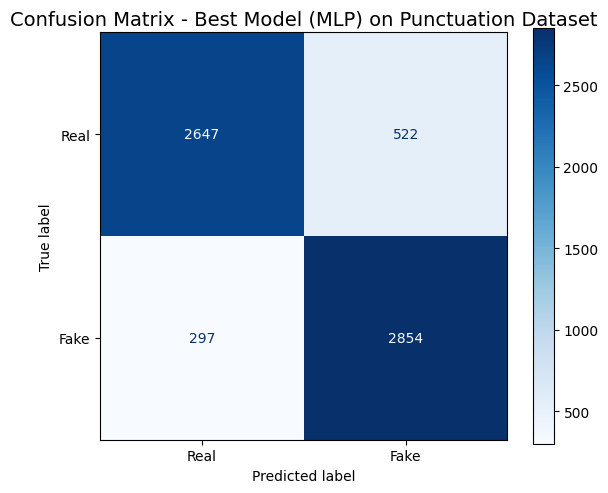

In [4]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Loading the model
best_model = joblib.load("../artifacts/punctuation/models/mlp_best.joblib")

# Predict on test set
y_pred = best_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Real", "Fake"])

# Plot
plt.figure(figsize=(6,5))
disp.plot(cmap="Blues", values_format="d", ax=plt.gca())
plt.title("Confusion Matrix - Best Model (MLP) on Punctuation Dataset", fontsize=14)
plt.tight_layout()
plt.savefig("../../report/assets/best_model/confusion_matrix_best_model.png")
plt.show()


## Prediction Probability Histogram
- Shows the distribution of predicted probabilities for each class.
- Useful to see how confident the model is in its predictions.

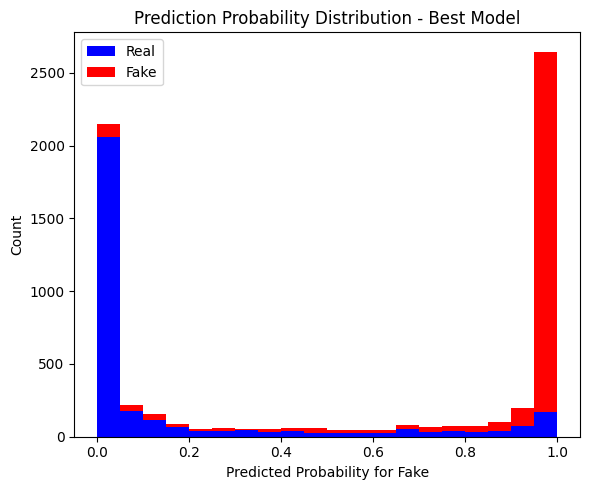

In [5]:
probs = best_model.predict_proba(X_test)[:,1]  # probability for Fake
plt.figure(figsize=(6,5))
plt.hist([probs[y_test==0], probs[y_test==1]], bins=20, stacked=True, color=['blue','red'], label=['Real','Fake'])
plt.xlabel("Predicted Probability for Fake")
plt.ylabel("Count")
plt.title("Prediction Probability Distribution - Best Model")
plt.legend()
plt.tight_layout()
plt.savefig("../../report/assets/best_model/probability_histogram_best_model.png")
plt.show()


## Misclassified Samples Inspection
- Scatter plot of predicted probability vs actual label, highlighting misclassified points.
- Highlights borderline cases.

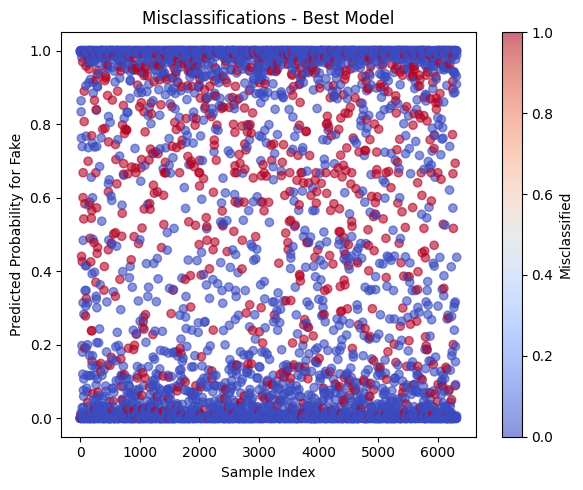

In [8]:
y_pred = best_model.predict(X_test)
plt.figure(figsize=(6,5))
plt.scatter(range(len(y_test)), best_model.predict_proba(X_test)[:,1], c=(y_pred!=y_test), cmap='coolwarm', alpha=0.6)
plt.xlabel("Sample Index")
plt.ylabel("Predicted Probability for Fake")
plt.title("Misclassifications - Best Model")
plt.colorbar(label='Misclassified')
plt.tight_layout()
plt.savefig("../../report/assets/best_model/misclassified_samples_best_model.png")
plt.show()


## Cumulative Accuracy vs Probability Threshold
- Shows how accuracy changes if you only accept predictions above a certain probability.
- Can help justify setting a threshold different from 0.5.

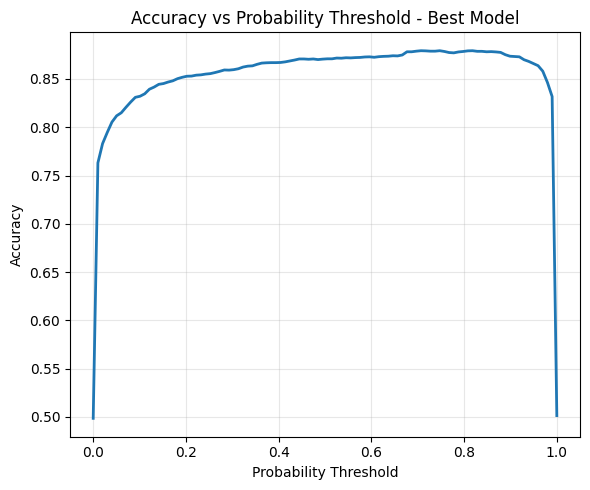

In [9]:
thresholds = np.linspace(0,1,100)
accuracies = [np.mean((best_model.predict_proba(X_test)[:,1] > t) == y_test) for t in thresholds]

plt.figure(figsize=(6,5))
plt.plot(thresholds, accuracies, lw=2)
plt.xlabel("Probability Threshold")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Probability Threshold - Best Model")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("../../report/assets/best_model/accuracy_vs_threshold_best_model.png")
plt.show()
